In [5]:
%matplotlib notebook
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pygalmesh
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys
sys.path.append('..')
import project

In [7]:
case_name = 'Case1Pack'
ee_phase = 50
ei_phase =  0

In [8]:
ds = project.imaging.Emory4DCTDataset('../data/Emory-4DCT', case_names=[case_name], phases=[ei_phase, ee_phase])
ds.load_niftis()
ds.load_masks(roi=['lung_combined_mask', 'body'])
ds.load_displacements(fixed_phase=ee_phase)

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T50/body.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T00_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/CorrField/case1_T50_T50.nii.gz


In [9]:
case = ds[0]

ee_anat_image = case.array.sel(phase=50)
ei_anat_image = case.array.sel(phase=0)

ee_lung_mask = case.mask.sel(phase=50, roi='lung_combined_mask')
ei_lung_mask = case.mask.sel(phase=0, roi='lung_combined_mask')

ee_overlay = (ee_lung_mask + 1) / 2
ei_overlay = (ei_lung_mask + 1) / 2

reg_disp_image = case.disp.sel(phase=0)

(256, 256, 94, 3)

<IPython.core.display.Javascript object>


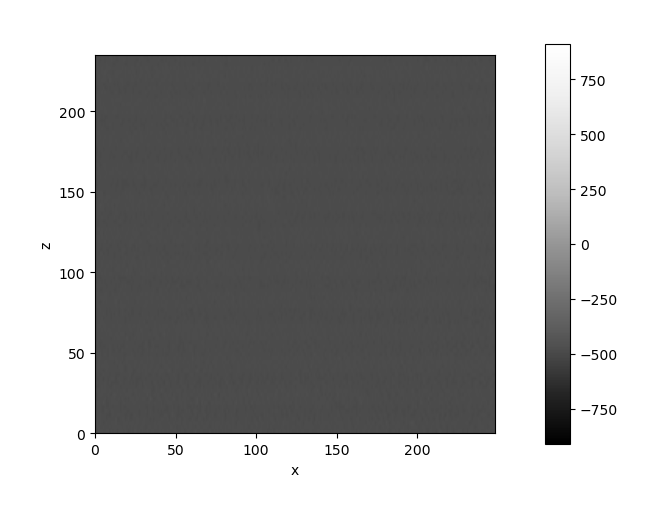

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [11]:
project.visual.view(ee_anat_image * ee_overlay, x='x', y='z', cmap='Greys_r')

<IPython.core.display.Javascript object>


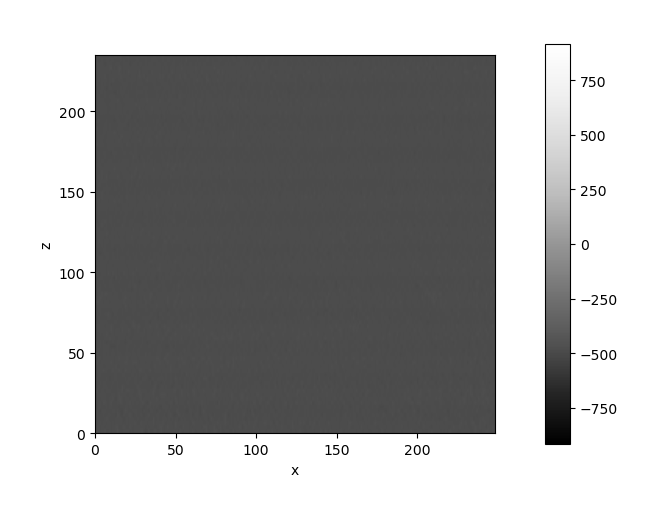

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [12]:
project.visual.view(ei_anat_image * ei_overlay, x='x', y='z', cmap='Greys_r')

<IPython.core.display.Javascript object>


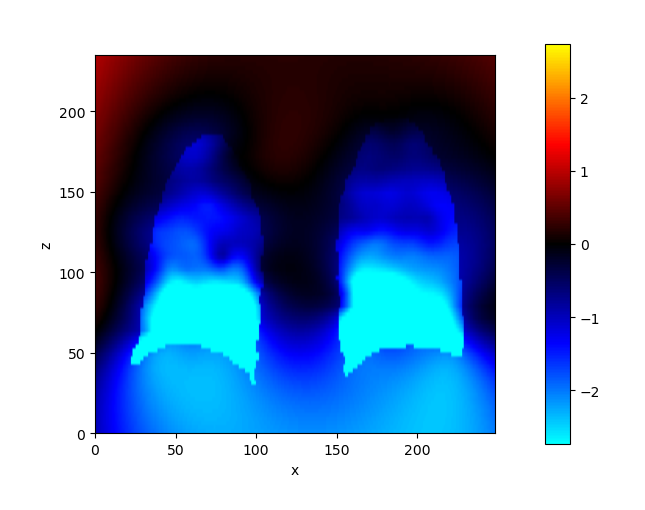

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [13]:
project.visual.view(reg_disp_image * ee_overlay, x='x', y='z')

<IPython.core.display.Javascript object>


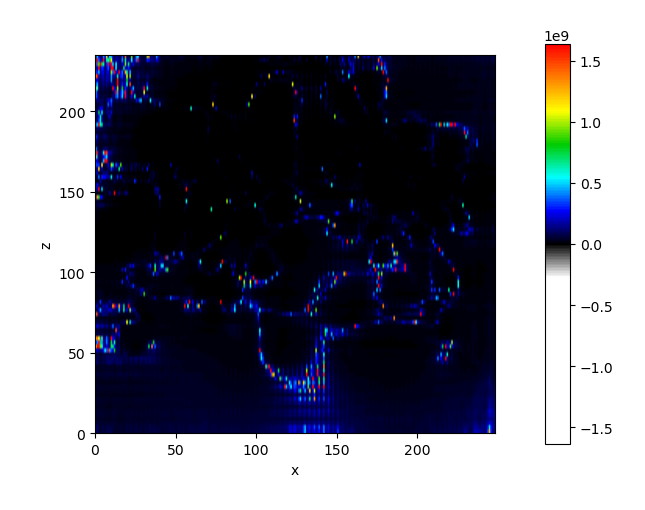

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [195]:
# direct inversion

dx_image = reg_disp_image.differentiate('x')
dy_image = reg_disp_image.differentiate('y')
dz_image = reg_disp_image.differentiate('z')

dxx_image = dx_image.differentiate('x')
dyy_image = dy_image.differentiate('y')
dzz_image = dz_image.differentiate('z')

laplacian_image = dxx_image + dyy_image + dzz_image

rho = 1000
omega = 2 * np.pi * 1
elast_image = -rho * omega**2 * (reg_disp_image.sum('component') / laplacian_image.sum('component'))
elast_image.name = 'elasticity'

project.visual.view(np.abs(elast_image) * ee_overlay, x='x', y='z', cmap=project.visual.mre_color_map())

In [196]:
%%time
ee_lung_mesh = pygalmesh.generate_from_array(
    ee_lung_mask.values.astype(np.uint16),
    voxel_size=case.resolution,
    max_cell_circumradius=20.0,
    odt=True
)

CPU times: user 113 ms, sys: 12.7 ms, total: 126 ms
Wall time: 128 ms


In [197]:
vertices = ee_lung_mesh.points
facets = ee_lung_mesh.cells[0].data
tetras = ee_lung_mesh.cells[1].data

tetra_facets = np.concatenate([
    tetras[:,[0,1,2]],
    tetras[:,[0,1,3]],
    tetras[:,[0,2,3]],
    tetras[:,[1,2,3]],
    
    tetras[:,[2,1,0]],
    tetras[:,[3,1,0]],
    tetras[:,[3,2,0]],
    tetras[:,[3,2,1]],
])

angles = project.meshing.compute_angles_to_interior(vertices, facets, tetras)
tetra_angles = project.meshing.compute_angles_to_interior(vertices, tetra_facets, tetras)

vertices.shape, facets.shape, tetras.shape

((301, 3), (920, 3), (997, 4))

<IPython.core.display.Javascript object>


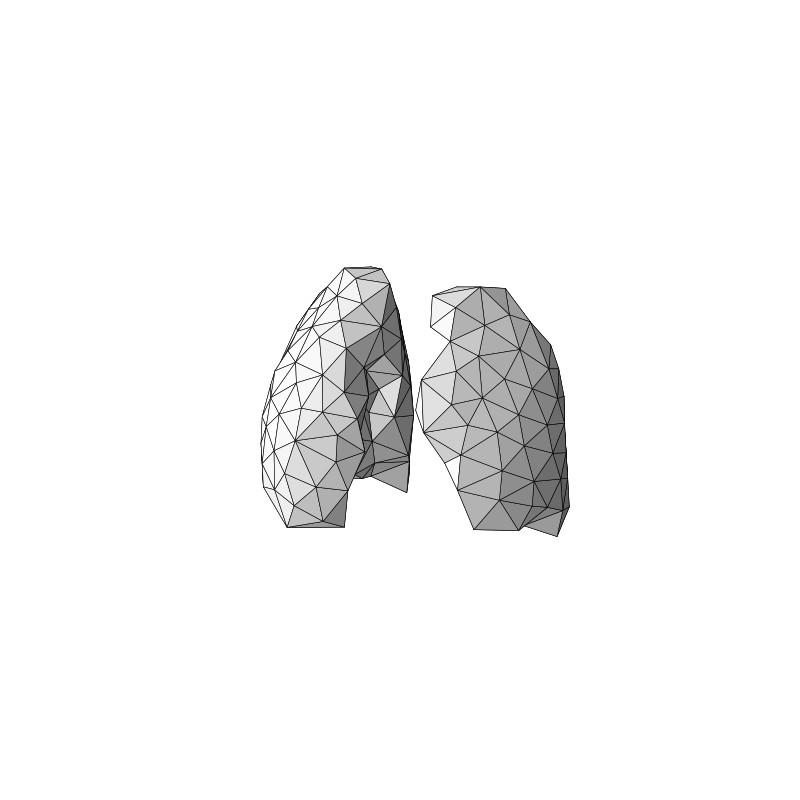

In [187]:
# view surface mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    facets[angles > 0],
    facecolors='white',
    edgecolors='black',
    shade=True,
    alpha=1.0,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

<IPython.core.display.Javascript object>


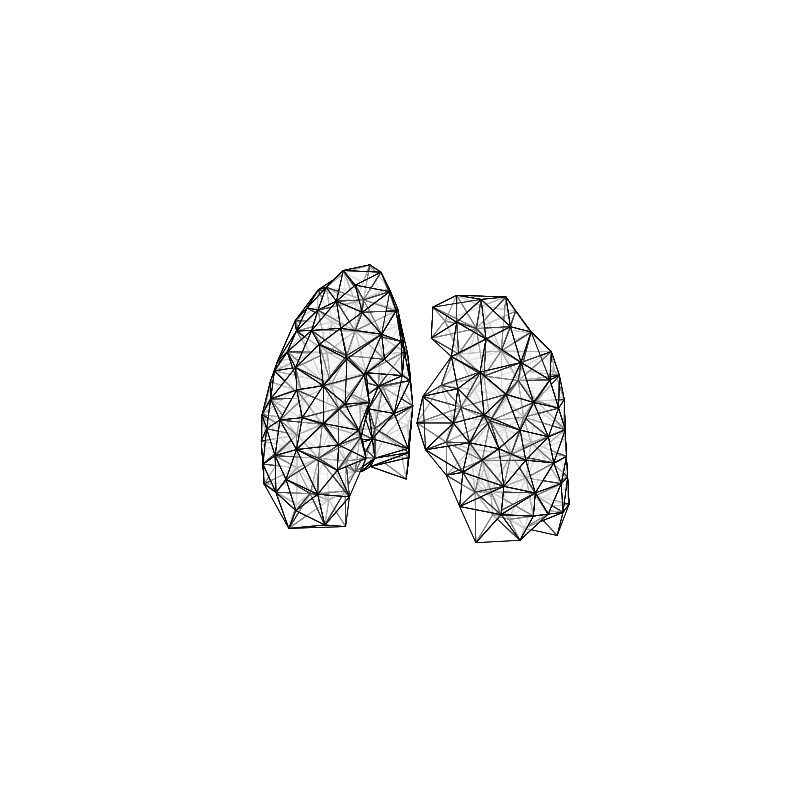

In [198]:
# view volume mesh

fig, ax = project.meshing.plot_mesh(
    vertices,
    tetra_facets,
    facecolors='white',
    edgecolors='black',
    alpha=0.1,
    linewidth=0.4,
    figsize=(8,8)
)
ax.grid(False)
ax.xaxis.set_pane_color((1,1,1,0))
ax.yaxis.set_pane_color((1,1,1,0))
ax.zaxis.set_pane_color((1,1,1,0))
ax.set_axis_off()

In [201]:
import meshio
import fenics as fe
from mpi4py import MPI

In [202]:
def convert_to_fe_mesh(points, cells):
    '''
    Convert from meshio to fenics mesh.
    '''
    mesh_file = 'temp.xdmf'
    meshio.write_points_cells(mesh_file, points, [(cells.type, cells.data)])
    fe_mesh = fe.Mesh()
    with fe.XDMFFile(MPI.COMM_WORLD, mesh_file) as f:
        f.read(fe_mesh)
    return fe_mesh

ee_lung_fe_mesh = convert_to_fe_mesh(ee_lung_mesh.points, ee_lung_mesh.cells[1])

In [213]:
import torch_fenics

In [ ]:
m = ee_lung_fe_mesh

reg_disp_values = reg_disp_image.values.reshape(-1, 3)
print(reg_disp_values.shape)

In [219]:
torch_fenics.numpy_fenics.numpy_to_fenics(reg_disp_values, fe.Function(fe.VectorFunctionSpace(ee_lung_fe_mesh, 'P', 1)))

(6160384, 3)


ValueError: Cannot convert numpy array to Function: Wrong shape (6160384, 3) vs (903,)

$$
\begin{align*}
    -\nabla\cdot\sigma &= \mathbf{b} \\
    -\int_\Omega (\nabla\cdot\sigma)\cdot\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} \\
    \int_\Omega \sigma\cdot\nabla\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} (\sigma\cdot\mathbf{n})\cdot\mathbf{v} \,d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u})\cdot\epsilon(\mathbf{v}) \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} \mathbf{t}\cdot\mathbf{v} \,d\mathbf{s}
\end{align*}
$$

In [224]:
u[0,0,0]

<xarray.DataArray 'displacement' (component: 3)> Size: 24B
array([-0.19725657,  0.18855788,  3.72065806])
Coordinates:
    phase      int64 8B 0
    x          float64 8B 0.0
    y          float64 8B 0.0
    z          float64 8B 0.0
  * component  (component) <U1 12B 'x' 'y' 'z'

In [226]:
import scipy

u = reg_disp_image



array([[-0.19725657,  0.18855788,  3.72065806],
       [-0.19315469,  0.18902737,  3.67161812]])

In [233]:
def solve_fem(mesh, u_image):
    
    # define physical parameters
    g   = 9.8 # gravitational acc (m/s^2)
    rho = 1.0 # mass density (kg/m^3)
    
    E  = 3e3 # Young's modulus (Pa = Na/m^2)
    nu = 0.4 # Poisson's ratio (unitless)

    lam = E*nu/((1 + nu)*(1 - 2*nu)) # Lame's first parameter (Pa)
    mu  = E   /(2*(1 + nu))          # shear modulus (Pa) 
    print(lam, mu)
    
    # initialize function space
    V = fe.VectorFunctionSpace(mesh, 'P', 1)
    
    # set displacement boundary condition
    def clamped_boundary(x, on_boundary):
        return on_boundary
        
    class XArrayExpression(fe.UserExpression):
        def __init__(self, array):
            super().__init__()
            self.interp = scipy.interpolate.RegularGridInterpolator(
                points=(array.x, array.y, array.z),
                values=array.values,
                method='linear'
            )
        def eval(self, values, x):
            values[...] = self.interp(x)
        def value_shape(self):
            return (3,)
            
    u_true = XArrayExpression(u_image)
    
    bc = fe.DirichletBC(V, u_true, clamped_boundary)
    
    # body force and traction
    b = fe.Constant((0, 0, -rho * g))
    t = fe.Constant((0, 0, 0))
    
    # define stress and strain
    def epsilon(u):
        return (fe.grad(u) + fe.grad(u).T) / 2

    def sigma(u):
        I = fe.Identity(u.geometric_dimension())
        return lam * fe.div(u) * I + 2 * mu * epsilon(u)

    # setup variational problem
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    a = fe.inner(sigma(u), epsilon(v)) * fe.dx
    L = fe.dot(b, v) * fe.dx + fe.dot(t, v) * fe.ds
    
    # solve for displacement
    u = fe.Function(V)
    fe.solve(a == L, u, bc)
    
    return u

disp_fe_func = solve_fem(ee_lung_fe_mesh, reg_disp_image)

4285.714285714287 1071.4285714285716


<IPython.core.display.Javascript object>


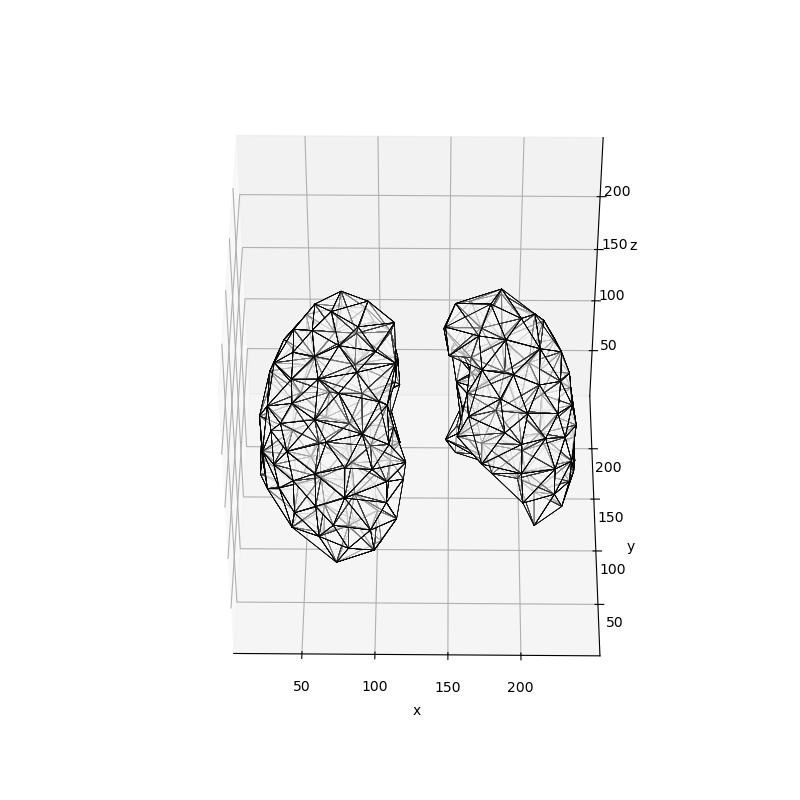

(<Figure size 800x800 with 1 Axes>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>)

In [234]:
f = disp_fe_func
m = f.function_space().mesh()

m_vertices = m.coordinates()
f_values = f.compute_vertex_values(m).reshape(3, -1).T

project.meshing.plot_mesh(
    m_vertices + f_values,
    tetra_facets,
    facecolors='white',
    edgecolors='black',
    shade=False,
    alpha=0.1,
    linewidth=0.4,
    figsize=(8,8)
)

In [235]:
np.linalg.norm(vertices - m_vertices)

0.0

<IPython.core.display.Javascript object>


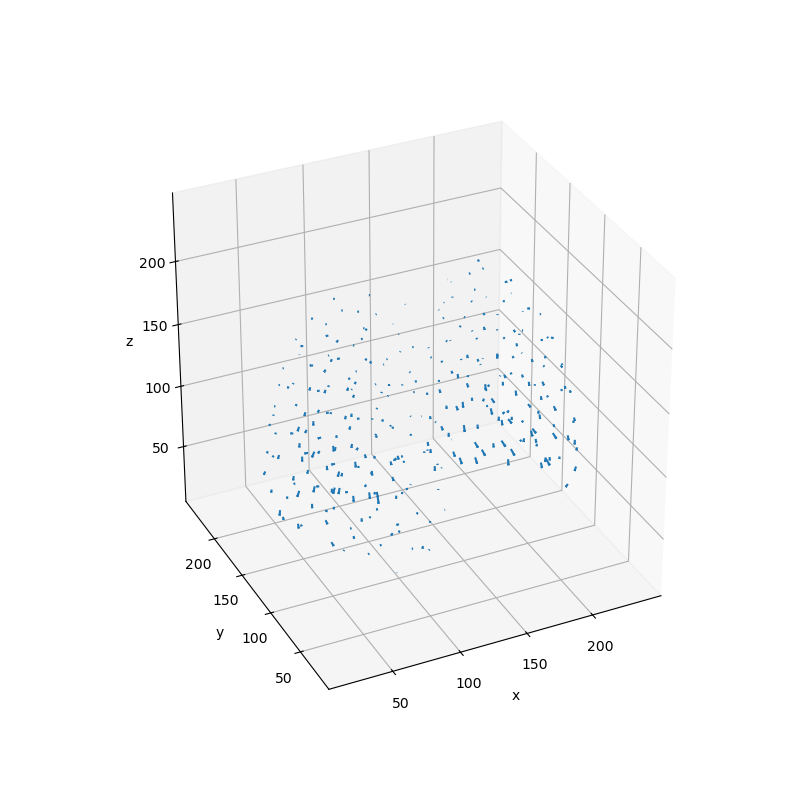

22.172420473544282


(<Figure size 800x800 with 1 Axes>,
 <Axes3D: xlabel='x', ylabel='y', zlabel='z'>)

In [236]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_func(f):

    mesh = f.function_space().mesh()

    vertices = mesh.coordinates()
    n_vertices = mesh.num_vertices()
    values = f.compute_vertex_values(mesh)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d', aspect='equal')

    X = [vertices[:,i] for i in range(3)]
    U = [values[i * n_vertices:(i + 1) * n_vertices] for i in range(3)]
    
    print(np.mean(np.linalg.norm(U, axis=1), axis=0))
       
    args = X + U
    ax.quiver(*args)
    
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

plot_func(disp_fe_func)

In [237]:
%%time
def get_grid_points(shape, resolution, flatten=False):
    assert len(shape) == len(resolution)
    coords = [np.arange(s) * r for s,r in zip(shape, resolution)]
    points = np.stack(np.meshgrid(*coords, indexing='ij'), axis=-1)
    if flatten:
        points = points.reshape(-1, len(shape))
    return points

points = get_grid_points(case.shape, case.resolution, flatten=True)

disp_fe_func.set_allow_extrapolation(True)
sim_disp_values = []
for point in points:
    sim_disp_values.append(disp_fe_func(*point))

sim_disp_image = np.array(sim_disp_values).reshape(case.shape + (3,))

CPU times: user 1min 31s, sys: 443 ms, total: 1min 31s
Wall time: 1min 32s


<IPython.core.display.Javascript object>


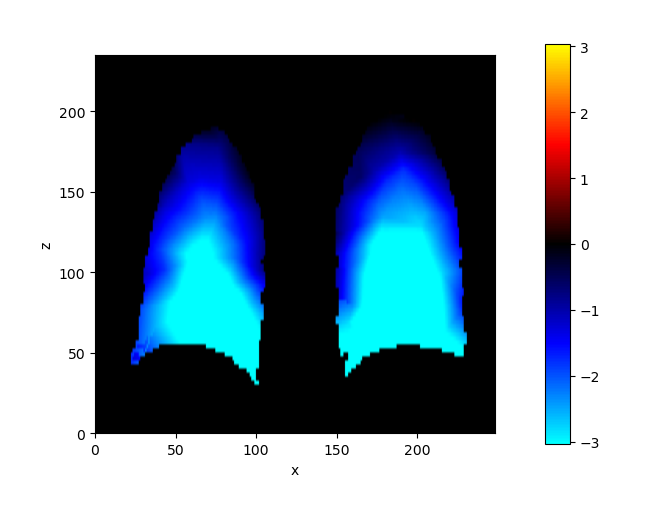

interactive(children=(SelectionSlider(description='y', options=((0.0, 0), (0.9700000286102295, 1), (1.94000005…

In [241]:
project.visual.view((reg_disp_image * 0 + sim_disp_image) * ee_lung_mask, x='x', y='z')